### Introduction
Briefly describe the project, its objectives, and the dataset you will use.

### Setup and Imports
Import necessary libraries (`tensorflow`, `numpy`, `matplotlib`, etc.).

In [111]:
'''Setup and Imports'''
import numpy as np
import tensorflow as tf
# from tensorflow.keras.optimizers import Adam
# If the warning persists, you might try using the legacy optimizer as follows:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras import layers, models # for defining the generator and discriminator networks
import numpy as np # for numerical operations
import matplotlib.pyplot as plt # for data visualization
from PIL import Image # for loading images
import matplotlib.image as mpimg # for loading images
import matplotlib.pyplot as plt
import pandas as pd # for data visualization
import sklearn # for any additional machine learning utilities
from sklearn.preprocessing import MultiLabelBinarizer # for one-hot encoding of ingredient labels
from sklearn.model_selection import train_test_split # for splitting the dataset
import skimage # for image processing
from skimage.transform import resize
from skimage.io import imread
import os

### Dataset Loading and Preprocessing
- Load your dataset of smoothie images.
- Preprocess images (resizing, normalization).
- Split the dataset into training and testing sets.

This code combines loading, preprocessing, encoding, and splitting into a single cell, ensuring that `X_train`, `X_val`, `y_train`, and `y_val` are properly defined and available for training and validation.

In [112]:
'''Dataset Loading and Preprocessing'''
# Define the path to your JSON file
# dataset_path = 'datasets/smoothies.json'
file_path = '/Users/brandiellenkinard/Documents/000-smoothie-ingredients/myproject/smoothie-cGAN/datasets/datasets/smoothies.json'

# Load the dataset
dataset = pd.read_json(file_path)

# Normalization helps the model learn more efficiently. This is important for neural network training, because it helps with the convergence of the model.
# Pixel values range from 0 to 255, so dividing by 255 will scale them to the [0,1] range, which is common and works well for most models.
def preprocess_image(image_path, target_size=(128, 128)):
    # Ensure the full path is correctly constructed from the notebook's location
    full_image_path = os.path.abspath(image_path)
    try:
        with Image.open(full_image_path) as img:
            # Rest of your preprocessing code here
            img = img.convert('RGBA')  # Convert to RGBA to handle transparency
            canvas = Image.new('RGBA', img.size, "WHITE")  # Create a white canvas
            canvas.paste(img, mask=img.split()[3])  # Paste using alpha channel as mask
            img = canvas.convert('RGB')  # Convert back to RGB
            img = img.resize(target_size)
            img = np.array(img) / 255.0  # Normalize pixel values
        return img
    except IOError as e:
        print(f"Error opening or processing image {full_image_path}: {e}")
        return None

# Correctly update image paths relative to the notebook's current directory
dataset['image'] = dataset['image'].apply(lambda x: os.path.join('..', 'datasets', x))

# Preprocess images and convert them into an array X
# Ensure that only existing paths are passed to the preprocessing function
X = np.array(dataset['image'].apply(preprocess_image).tolist())

# Encode ingredient labels
unique_ingredients = set(item for sublist in dataset['ingredients'] for item in sublist)
mlb = MultiLabelBinarizer(classes=sorted(unique_ingredients))
y = mlb.fit_transform(dataset['ingredients'])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

image_shape = (128, 128, 3)  # After preprocessing images
num_tags = y.shape[1]  # Number of unique tags

### Data Augmentation
- Implement data augmentation techniques to diversify your training dataset and improve model robustness.

In [113]:
'''Data Augmentation'''
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation configuration
data_augmentation = ImageDataGenerator(
    rotation_range=20,      # Random rotations. Random rotation between 0 and 10 degrees. Used to be 10
    width_shift_range=0.2,  # Random horizontal shifts. Fraction of total width for horizontal shift. Used to be 0.1
    height_shift_range=0.2, # Random vertical shifts. Fraction of total height for vertical shift. Used to be 0.1
    shear_range=0.15,        # Shear transformations. Used to be 0.1
    zoom_range=0.2,         # Random zoom. Random zoom between 90% (0.9) and 110% (1.1). Used to be 0.1
    channel_shift_range=30, # Add channel shifting for color variation
    vertical_flip=True,     # Add vertical flips for more variability
    horizontal_flip=True,   # Horizontal flips. Randomly flip inputs horizontally. 
    fill_mode='reflect'     # Fill strategy. Strategy for filling in newly created pixels. Used to be nearest
)

### Model 
- Define the diffusion model architecture. This can be challenging without specific code examples for diffusion models, as they are complex and involve nuanced implementation details. You might start with simpler generative models to gain more experience.
In a diffusion model, you typically need two main components: the model that predicts the noise (often a U-Net architecture for images), and the diffusion process itself which involves a series of forward (noising) and reverse (denoising) steps.
- U-Net Architecture for Images: This CNN architecture is effective for tasks that require understanding the context of the entire image, such as generating or denoising images. It consists of a contracting path to capture context and a symmetric expanding path that enables precise localization.

In [114]:
'''Model Architecture'''
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    
    # Downsample
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    
    # Upsample
    u4 = UpSampling2D((2, 2))(c3)
    u4 = Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same')(u4)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

    u5 = UpSampling2D((2, 2))(c4)
    u5 = Conv2DTranspose(16, (3, 3), strides=(1, 1), padding='same')(u5)
    u5 = concatenate([u5, c1], axis=3)
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Output layer
    output = Conv2D(3, (1, 1), activation='tanh')(c5)
    
    return Model(inputs=inputs, outputs=output)


### Training Setup
- Define the loss functions, optimizers, and training loop.
- Implement the forward and reverse processes of the diffusion model.

Implemented in the following cell:
- Diffusion Process: involves defining the forward process (adding noise) and the reverse process (model learning to reverse the noising process)
- Loss Function: a mean squared error (MSE) between the original images and the reconstructed images
- Optimizer: Adam optimizer

In [115]:
'''Training Setup'''
# Assuming 'unet_model' is your U-Net model function from the previous cell
model = unet_model(input_size=(128, 128, 3))

# Loss function
loss_function = MeanSquaredError()

# Optimizer
optimizer = Adam(learning_rate=7e-3) # used to be `1e-4` (0.0001)

model.compile(optimizer=optimizer, loss=loss_function)

# Forward process - Adding noise
def add_noise(images, noise_factor=0.1):
    """
    Adds Gaussian noise to each image.
    """
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, -1.0, 1.0)  # Ensure the images are still in [-1, 1]
    return noisy_images

# Reverse process - This is implicitly learned by the model during training
# by trying to reconstruct the original images from the noisy images.



### Training Execution
- Run the training loop, periodically saving generated images to monitor progress.

Inluced in the following cell:
- Iterate over epochs
- In each epoch, run the forward diffusion process to add noise to the images, then run the reverse process where the model learns to reconstruct the original images from the noised images
- Update the model weights based on the loss between the reconstructed images and the original images

This code snippet includes the training loop where:
- Noise is added to the original images to simulate the forward diffusion process.
- The model learns to reconstruct the original images from their noisy counterparts.
- Training loss is recorded and printed at the end of each epoch.
- Sample images (original, noisy, and reconstructed) are displayed at specified intervals to visually assess the model's performance.
- Training loss is plotted over epochs to visualize the learning progress.

2024-03-03 06:40:38.206823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:40:39.124018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 1, Loss: 1.558702290058136


2024-03-03 06:40:39.746697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:40:40.360927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 2, Loss: 0.6212201341986656


2024-03-03 06:40:40.966522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:40:41.535267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 3, Loss: 0.07743745297193527


2024-03-03 06:40:42.113561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:40:42.697714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 4, Loss: 0.06672085076570511


2024-03-03 06:40:43.283387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:40:43.883596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 5, Loss: 0.040437204763293266


2024-03-03 06:40:44.471338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:40:45.071625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 6, Loss: 0.03133698180317879


2024-03-03 06:40:45.696461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:40:46.315671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 7, Loss: 0.02664234582334757


2024-03-03 06:40:46.907801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:40:47.507047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 8, Loss: 0.026470967568457127


2024-03-03 06:40:48.111271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:40:48.703342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 9, Loss: 0.0269657326862216


2024-03-03 06:40:49.323940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:40:49.939871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 10, Loss: 0.02054204512387514
1/1 [==============================] - 0s 217ms/step


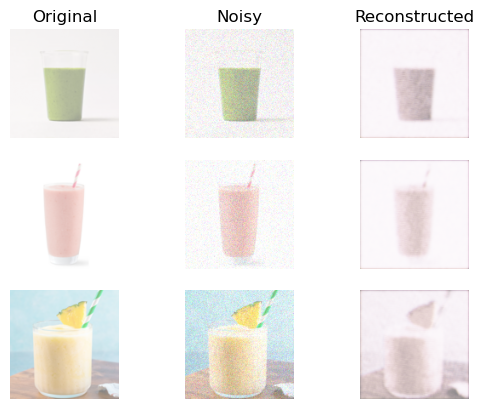

2024-03-03 06:40:50.938637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:40:51.551299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 11, Loss: 0.02023153007030487


2024-03-03 06:40:52.155493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:40:52.762421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 12, Loss: 0.02284151967614889


2024-03-03 06:40:53.341908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:40:53.952875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 13, Loss: 0.016847630962729454


2024-03-03 06:40:54.562870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:40:55.177524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 14, Loss: 0.016979269683361053


2024-03-03 06:40:55.776613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:40:56.387203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 15, Loss: 0.014593200758099556


2024-03-03 06:40:57.062970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:40:57.716824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 16, Loss: 0.015055564697831869


2024-03-03 06:40:58.415586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:40:59.035456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 17, Loss: 0.01261805510148406


2024-03-03 06:40:59.660759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:00.303991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 18, Loss: 0.016540994867682457


2024-03-03 06:41:01.080902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:01.698972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 19, Loss: 0.01439049281179905


2024-03-03 06:41:02.325273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:02.926556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 20, Loss: 0.013157959561794996
1/1 [==============================] - 0s 166ms/step


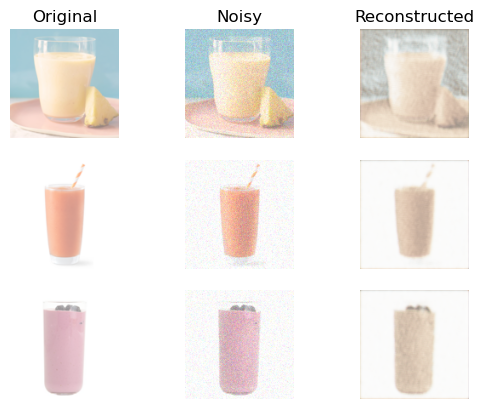

2024-03-03 06:41:03.834124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:04.481556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 21, Loss: 0.012950603384524584


2024-03-03 06:41:05.136225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:05.739315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 22, Loss: 0.011354002170264721


2024-03-03 06:41:06.332708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:06.928992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 23, Loss: 0.011486269999295473


2024-03-03 06:41:07.544944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:08.158762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 24, Loss: 0.013275900855660439


2024-03-03 06:41:08.747870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:09.348493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 25, Loss: 0.010286475531756878


2024-03-03 06:41:09.960060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:10.544475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 26, Loss: 0.009721705224364996


2024-03-03 06:41:11.139611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:11.746324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 27, Loss: 0.009111559484153986


2024-03-03 06:41:12.359932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:12.968846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 28, Loss: 0.010142929386347532


2024-03-03 06:41:13.541534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:14.123708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 29, Loss: 0.009469352662563324


2024-03-03 06:41:14.700814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:15.309579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 30, Loss: 0.009265691507607698
1/1 [==============================] - 0s 155ms/step


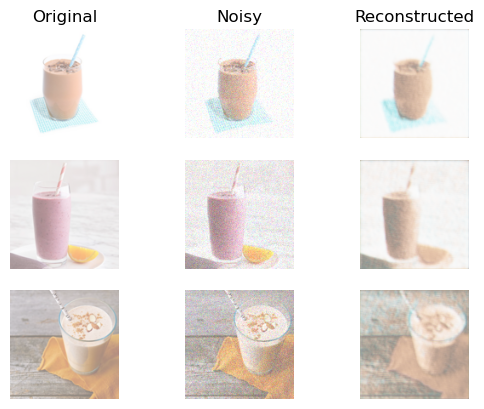

2024-03-03 06:41:16.192441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:16.781654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 31, Loss: 0.008613606449216604


2024-03-03 06:41:17.340171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:17.907271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 32, Loss: 0.0077107432298362255


2024-03-03 06:41:18.468599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:19.032462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 33, Loss: 0.007839733734726906


2024-03-03 06:41:19.599112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:20.213755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 34, Loss: 0.00770848267711699


2024-03-03 06:41:20.772676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:21.369305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 35, Loss: 0.007144291652366519


2024-03-03 06:41:21.982929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:22.595645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 36, Loss: 0.008252662839367986


2024-03-03 06:41:23.205593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:23.807705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 37, Loss: 0.008122017607092857


2024-03-03 06:41:24.422416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:25.037591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 38, Loss: 0.00823292601853609


2024-03-03 06:41:25.644030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:26.233472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 39, Loss: 0.007057297974824905


2024-03-03 06:41:26.802884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:27.394477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 40, Loss: 0.008390656672418118
1/1 [==============================] - 0s 172ms/step


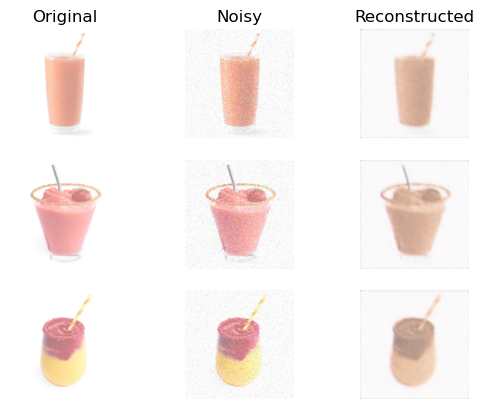

2024-03-03 06:41:28.552668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:29.217974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 41, Loss: 0.008281779009848833


2024-03-03 06:41:29.857624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:30.505060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 42, Loss: 0.007383967516943812


2024-03-03 06:41:31.093568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:31.662746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 43, Loss: 0.00726865348406136


2024-03-03 06:41:32.232931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:32.840311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 44, Loss: 0.006836556131020188


2024-03-03 06:41:33.445100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:34.066748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 45, Loss: 0.006696208147332072


2024-03-03 06:41:34.669080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:35.283029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 46, Loss: 0.0065961675718426704


2024-03-03 06:41:35.873529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:36.434914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 47, Loss: 0.006740395678207278


2024-03-03 06:41:37.015109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:37.618376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 48, Loss: 0.006534287007525563


2024-03-03 06:41:38.211855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:38.811413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 49, Loss: 0.006687060929834843


2024-03-03 06:41:39.417229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:40.012082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 50, Loss: 0.006370721617713571
1/1 [==============================] - 0s 160ms/step


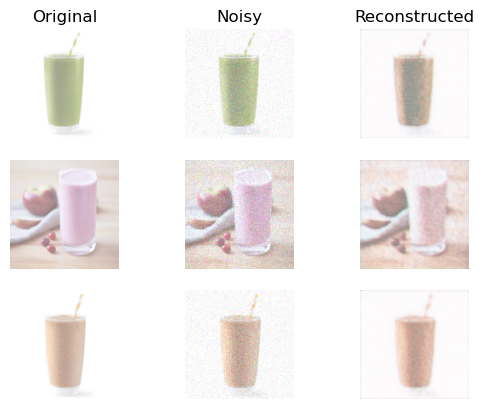

2024-03-03 06:41:40.917536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:41.501342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 51, Loss: 0.006142009980976582


2024-03-03 06:41:42.105209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:42.665910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 52, Loss: 0.005076645407825708


2024-03-03 06:41:43.227801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:43.782663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 53, Loss: 0.005059633171185851


2024-03-03 06:41:44.334027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:44.888677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 54, Loss: 0.005645425990223885


2024-03-03 06:41:45.466953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:46.113193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 55, Loss: 0.0055425032041966915


2024-03-03 06:41:46.715808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:47.272691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 56, Loss: 0.0048200758174061775


2024-03-03 06:41:47.822852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:48.380423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 57, Loss: 0.005010726861655712


2024-03-03 06:41:48.963783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:49.547440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 58, Loss: 0.004865347174927592


2024-03-03 06:41:50.114178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:50.667626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 59, Loss: 0.00510254199616611


2024-03-03 06:41:51.221325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:51.776528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 60, Loss: 0.005260170437395573
1/1 [==============================] - 0s 156ms/step


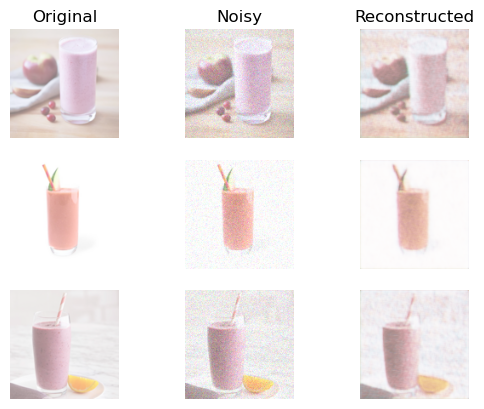

2024-03-03 06:41:52.695039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:53.276296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 61, Loss: 0.005132297519594431


2024-03-03 06:41:53.828311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:54.384672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 62, Loss: 0.004428726388141513


2024-03-03 06:41:54.981006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:55.534937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 63, Loss: 0.0046933479607105255


2024-03-03 06:41:56.087355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:56.664192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 64, Loss: 0.004977827193215489


2024-03-03 06:41:57.230562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:57.779645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 65, Loss: 0.005293339723721147


2024-03-03 06:41:58.336570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:41:58.892946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 66, Loss: 0.004782635718584061


2024-03-03 06:41:59.454841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:00.043493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 67, Loss: 0.004426921252161264


2024-03-03 06:42:00.737199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:01.309358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 68, Loss: 0.00454281410202384


2024-03-03 06:42:01.919098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:02.555939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 69, Loss: 0.004608735907822847


2024-03-03 06:42:03.116837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:03.716932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 70, Loss: 0.004285501083359122
1/1 [==============================] - 0s 168ms/step


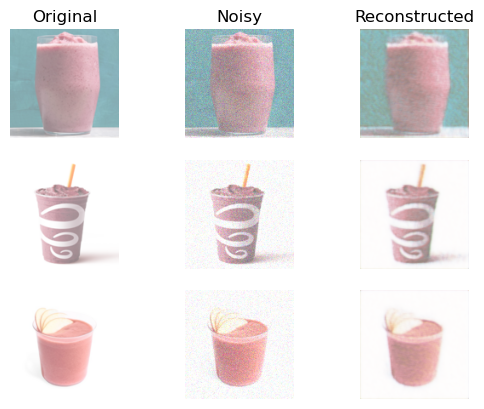

2024-03-03 06:42:04.699034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:05.297533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 71, Loss: 0.003962401300668716


2024-03-03 06:42:05.876955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:06.450065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 72, Loss: 0.004062562016770244


2024-03-03 06:42:07.028502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:07.585638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 73, Loss: 0.003774390439502895


2024-03-03 06:42:08.151191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:08.739630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 74, Loss: 0.0040628984570503235


2024-03-03 06:42:09.298033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:09.894092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 75, Loss: 0.0039811196038499475


2024-03-03 06:42:10.476016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:11.065714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 76, Loss: 0.004007637733593583


2024-03-03 06:42:11.629179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:12.192944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 77, Loss: 0.004348881542682648


2024-03-03 06:42:12.745584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:13.314766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 78, Loss: 0.0037669575540348887


2024-03-03 06:42:13.895775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:14.461287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 79, Loss: 0.003771952004171908


2024-03-03 06:42:15.031842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:15.609119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 80, Loss: 0.003569146618247032
1/1 [==============================] - 0s 155ms/step


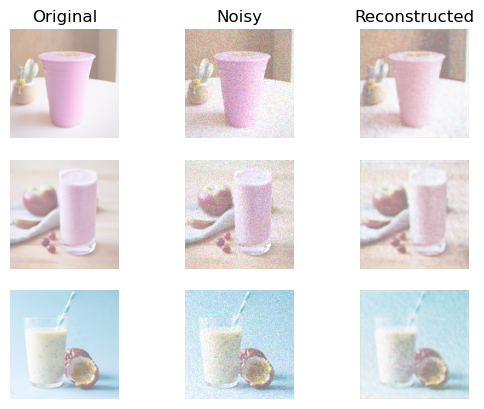

2024-03-03 06:42:16.515157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:17.110577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 81, Loss: 0.004134415416046977


2024-03-03 06:42:17.677972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:18.299329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 82, Loss: 0.004096997901797295


2024-03-03 06:42:18.895232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:19.466953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 83, Loss: 0.003796998760662973


2024-03-03 06:42:20.090764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:20.685290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 84, Loss: 0.004079834092408419


2024-03-03 06:42:21.253284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:21.839686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 85, Loss: 0.0037221541861072183


2024-03-03 06:42:22.407251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:22.974523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 86, Loss: 0.0033950379583984613


2024-03-03 06:42:23.548628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:24.118149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 87, Loss: 0.00417429581284523


2024-03-03 06:42:24.696697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:25.280366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 88, Loss: 0.004831748781725764


2024-03-03 06:42:25.861380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:26.419447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 89, Loss: 0.004208203637972474


2024-03-03 06:42:27.002236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:27.575400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 90, Loss: 0.004979365039616823
1/1 [==============================] - 0s 159ms/step


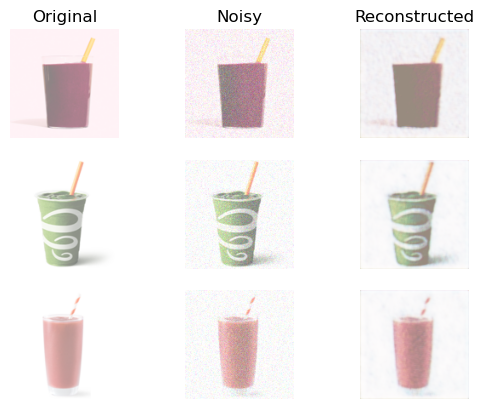

2024-03-03 06:42:28.458081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:29.029966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 91, Loss: 0.00829627551138401


2024-03-03 06:42:29.586698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:30.136727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 92, Loss: 0.006778123788535595


2024-03-03 06:42:30.704239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:31.252933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 93, Loss: 0.00634119170717895


2024-03-03 06:42:31.805870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:32.352866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 94, Loss: 0.006441905628889799


2024-03-03 06:42:32.917778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:33.477135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 95, Loss: 0.00478074885904789


2024-03-03 06:42:34.064177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:34.714530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 96, Loss: 0.005570596898905933


2024-03-03 06:42:35.310976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:35.952406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 97, Loss: 0.007182487286627293


2024-03-03 06:42:36.603637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:37.200452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 98, Loss: 0.006751153850927949


2024-03-03 06:42:37.762299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:38.320689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 99, Loss: 0.006899993401020765


2024-03-03 06:42:38.889129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:39.455201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 100, Loss: 0.00614735996350646
1/1 [==============================] - 0s 156ms/step


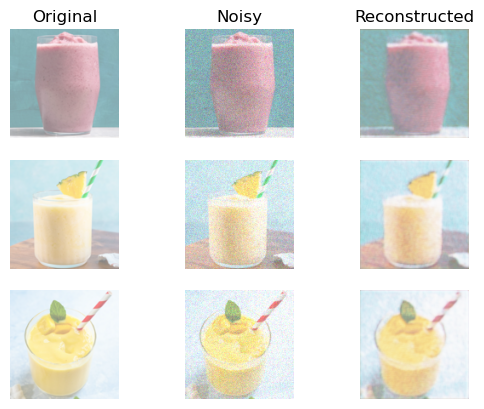

2024-03-03 06:42:40.367261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:40.972495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 101, Loss: 0.004860675428062677


2024-03-03 06:42:41.562692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:42.146027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 102, Loss: 0.0051320858765393496


2024-03-03 06:42:42.729989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:43.297592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 103, Loss: 0.004312865203246474


2024-03-03 06:42:43.866367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:44.437742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 104, Loss: 0.004074438940733671


2024-03-03 06:42:45.018488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:45.587060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 105, Loss: 0.004156231414526701


2024-03-03 06:42:46.147965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:46.738764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 106, Loss: 0.004250618163496256


2024-03-03 06:42:47.307838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:47.885946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 107, Loss: 0.003789875889196992


2024-03-03 06:42:48.467732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:49.048387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 108, Loss: 0.004019166924990714


2024-03-03 06:42:49.601151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:50.195732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 109, Loss: 0.003927333978936076


2024-03-03 06:42:50.799449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:51.404140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 110, Loss: 0.003570298897102475
1/1 [==============================] - 0s 198ms/step


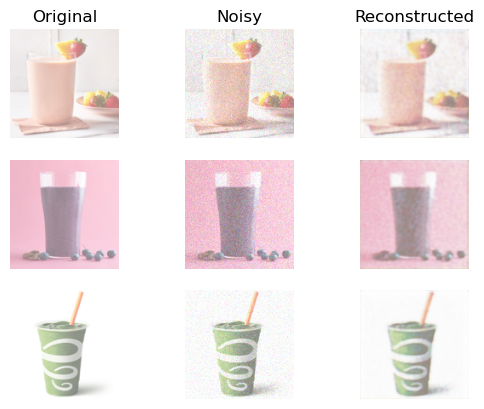

2024-03-03 06:42:52.383423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:52.973488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 111, Loss: 0.003801492159254849


2024-03-03 06:42:53.537233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:54.111210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 112, Loss: 0.0037595063913613558


2024-03-03 06:42:54.698530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:55.301357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 113, Loss: 0.0033685415983200073


2024-03-03 06:42:55.911665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:56.508199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 114, Loss: 0.003916877321898937


2024-03-03 06:42:57.108732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:57.729795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 115, Loss: 0.003454086370766163


2024-03-03 06:42:58.345848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:42:58.921345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 116, Loss: 0.0035769621608778834


2024-03-03 06:42:59.534417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:00.161332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 117, Loss: 0.0033785776467993855


2024-03-03 06:43:00.730406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:01.278630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 118, Loss: 0.003201016690582037


2024-03-03 06:43:01.870238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:02.464681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 119, Loss: 0.003502282314002514


2024-03-03 06:43:03.046362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:03.655192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 120, Loss: 0.0032485200790688396
1/1 [==============================] - 0s 154ms/step


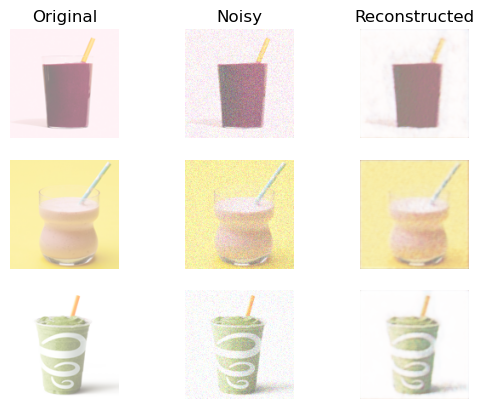

2024-03-03 06:43:04.579374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:05.160522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 121, Loss: 0.0036175056593492627


2024-03-03 06:43:05.730018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:06.328090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 122, Loss: 0.003303556120954454


2024-03-03 06:43:06.889615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:07.443338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 123, Loss: 0.0033280416391789913


2024-03-03 06:43:08.015945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:08.586329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 124, Loss: 0.003355341381393373


2024-03-03 06:43:09.164553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:09.735985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 125, Loss: 0.0033700402127578855


2024-03-03 06:43:10.282699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:10.848410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 126, Loss: 0.003386534401215613


2024-03-03 06:43:11.394996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:11.941536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 127, Loss: 0.003467162954621017


2024-03-03 06:43:12.543150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:13.135924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 128, Loss: 0.003535114577971399


2024-03-03 06:43:13.704964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:14.291988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 129, Loss: 0.003137229708954692


2024-03-03 06:43:14.865465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:15.423564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 130, Loss: 0.0030924429884180427
1/1 [==============================] - 0s 164ms/step


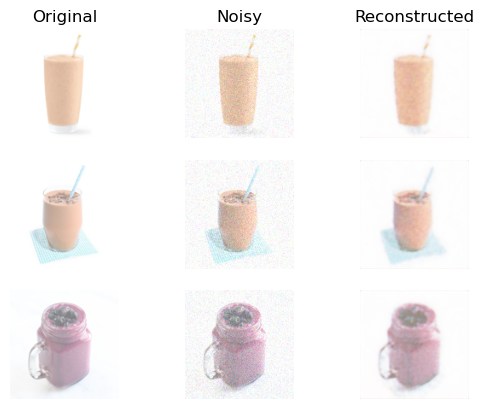

2024-03-03 06:43:16.503510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:17.112096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 131, Loss: 0.003065597149543464


2024-03-03 06:43:17.697009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:18.303115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 132, Loss: 0.0031825160840526223


2024-03-03 06:43:18.931090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:19.542880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 133, Loss: 0.003462885390035808


2024-03-03 06:43:20.151985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:20.715221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 134, Loss: 0.0034209740115329623


2024-03-03 06:43:21.295786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:21.912695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 135, Loss: 0.0032526832073926926


2024-03-03 06:43:22.586370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:23.197542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 136, Loss: 0.00342390825971961


2024-03-03 06:43:23.777272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:24.379329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 137, Loss: 0.003121028305031359


2024-03-03 06:43:24.964027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:25.531873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 138, Loss: 0.0029896546620875597


2024-03-03 06:43:26.114284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:26.683531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 139, Loss: 0.0027781466487795115


2024-03-03 06:43:27.268947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:27.832634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 140, Loss: 0.0033988228533416986
1/1 [==============================] - 0s 154ms/step


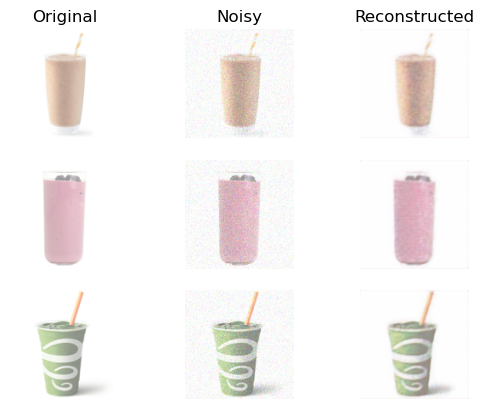

2024-03-03 06:43:28.726540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:29.306167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 141, Loss: 0.0031223315745592117


2024-03-03 06:43:29.873843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:30.456353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 142, Loss: 0.0031145006651058793


2024-03-03 06:43:31.025242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:31.591393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 143, Loss: 0.0030488759512081742


2024-03-03 06:43:32.153039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:32.736415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 144, Loss: 0.002950311405584216


2024-03-03 06:43:33.298328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:33.886828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 145, Loss: 0.002909235772676766


2024-03-03 06:43:34.485167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:35.072339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 146, Loss: 0.003162155277095735


2024-03-03 06:43:35.634502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:36.188976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 147, Loss: 0.0028583004605025053


2024-03-03 06:43:36.799540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:37.414031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 148, Loss: 0.0027152157854288816


2024-03-03 06:43:37.994463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:38.638714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 149, Loss: 0.0028276537777855992


2024-03-03 06:43:39.216773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:39.784423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 150, Loss: 0.0025470906402915716
1/1 [==============================] - 0s 157ms/step


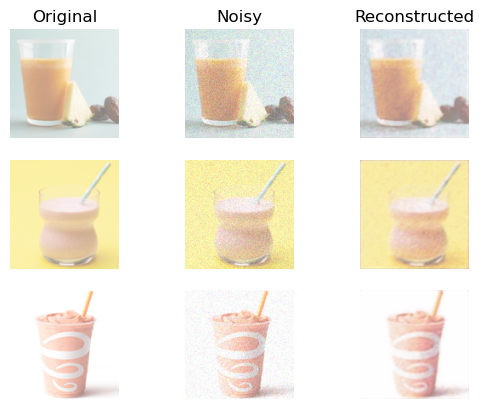

2024-03-03 06:43:40.684203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:41.300282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 151, Loss: 0.002980682300403714


2024-03-03 06:43:41.869560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:42.464466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 152, Loss: 0.0027795525966212153


2024-03-03 06:43:43.059703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:43.634869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 153, Loss: 0.0027594619896262884


2024-03-03 06:43:44.219608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:44.801887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 154, Loss: 0.0024655620800331235


2024-03-03 06:43:45.376223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:45.949475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 155, Loss: 0.00292758212890476


2024-03-03 06:43:46.537256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:47.125971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 156, Loss: 0.00258913217112422


2024-03-03 06:43:47.718733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:48.284809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 157, Loss: 0.0024184260983020067


2024-03-03 06:43:48.858547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:49.451344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 158, Loss: 0.004843874368816614


2024-03-03 06:43:50.037711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:50.625199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 159, Loss: 0.004153316025622189


2024-03-03 06:43:51.213516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:51.789982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 160, Loss: 0.004625742556527257
1/1 [==============================] - 0s 168ms/step


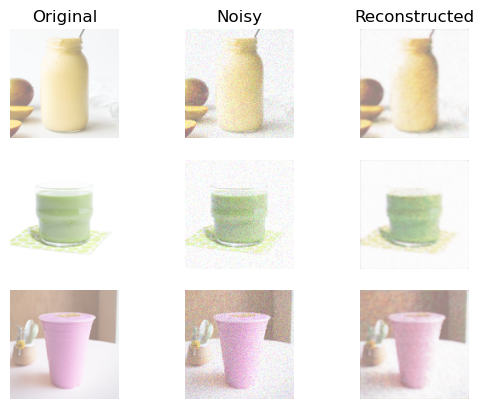

2024-03-03 06:43:52.745482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:53.312790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 161, Loss: 0.0052511978428810835


2024-03-03 06:43:53.875687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:54.524038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 162, Loss: 0.004487324506044388


2024-03-03 06:43:55.126073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:55.713970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 163, Loss: 0.004599768668413162


2024-03-03 06:43:56.327735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:56.946634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 164, Loss: 0.005302188452333212


2024-03-03 06:43:57.541129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:58.127543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 165, Loss: 0.004600351443514228


2024-03-03 06:43:58.762177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:43:59.353599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 166, Loss: 0.004521619528532028


2024-03-03 06:43:59.966823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:00.554365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 167, Loss: 0.0038302813190966845


2024-03-03 06:44:01.149709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:01.754963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 168, Loss: 0.0037389646749943495


2024-03-03 06:44:02.339950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:02.931066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 169, Loss: 0.0034572442527860403


2024-03-03 06:44:03.508989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:04.088292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 170, Loss: 0.0032564965076744556
1/1 [==============================] - 0s 161ms/step


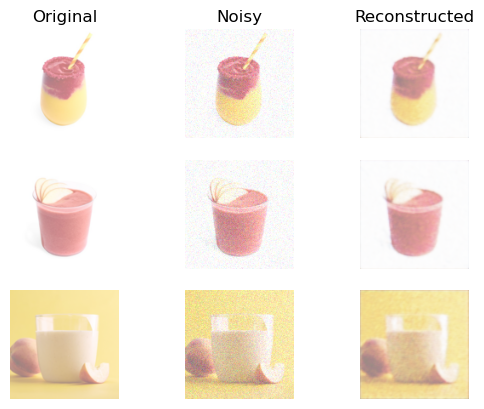

2024-03-03 06:44:04.986774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:05.578439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 171, Loss: 0.003125607967376709


2024-03-03 06:44:06.161468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:06.745522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 172, Loss: 0.0035402223002165556


2024-03-03 06:44:07.345218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:07.923678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 173, Loss: 0.0037099970504641533


2024-03-03 06:44:08.499942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:09.084327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 174, Loss: 0.0030384068377316


2024-03-03 06:44:09.655913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:10.275748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 175, Loss: 0.0030713332816958427


2024-03-03 06:44:10.838594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:11.405680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 176, Loss: 0.002856690320186317


2024-03-03 06:44:12.050561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:12.622352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 177, Loss: 0.003029842162504792


2024-03-03 06:44:13.205415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:13.786429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 178, Loss: 0.0030723275849595666


2024-03-03 06:44:14.397566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:15.003049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 179, Loss: 0.0028611263260245323


2024-03-03 06:44:15.574383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:16.138381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 180, Loss: 0.0027042606379836798
1/1 [==============================] - 0s 164ms/step


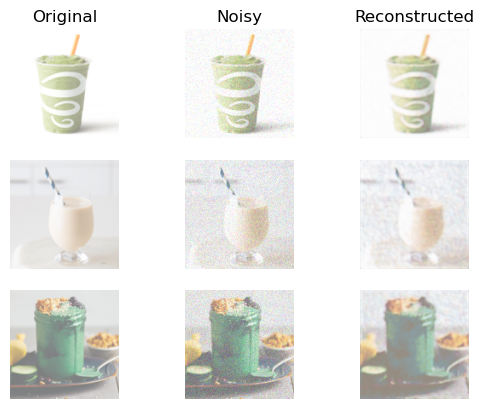

2024-03-03 06:44:17.055044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:17.639751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 181, Loss: 0.0026806744281202555


2024-03-03 06:44:18.216252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:18.785837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 182, Loss: 0.002926235436461866


2024-03-03 06:44:19.347724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:19.909747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 183, Loss: 0.003030792810022831


2024-03-03 06:44:20.493051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:21.076779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 184, Loss: 0.0028307621832937002


2024-03-03 06:44:21.647069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:22.219932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 185, Loss: 0.0028901820769533515


2024-03-03 06:44:22.863433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:23.439704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 186, Loss: 0.0031331422505900264


2024-03-03 06:44:24.001841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:24.573140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 187, Loss: 0.002828894997946918


2024-03-03 06:44:25.164793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:25.765636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 188, Loss: 0.0029494964983314276


2024-03-03 06:44:26.376492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:26.958380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 189, Loss: 0.002637566882185638


2024-03-03 06:44:27.530471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:28.091680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 190, Loss: 0.002597501967102289
1/1 [==============================] - 0s 157ms/step


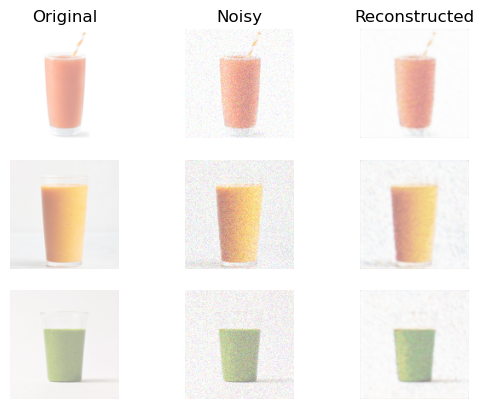

2024-03-03 06:44:29.004264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:29.594786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 191, Loss: 0.0025615565245971084


2024-03-03 06:44:30.173005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:30.765375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 192, Loss: 0.002872413955628872


2024-03-03 06:44:31.333578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:31.907502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 193, Loss: 0.0027551765087991953


2024-03-03 06:44:32.492949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:33.108489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 194, Loss: 0.002645122236572206


2024-03-03 06:44:33.711548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:34.318942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 195, Loss: 0.002734728390350938


2024-03-03 06:44:34.918698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:35.510537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 196, Loss: 0.0026547065936028957


2024-03-03 06:44:36.105386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:36.713832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 197, Loss: 0.002653935574926436


2024-03-03 06:44:37.306937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:37.877555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 198, Loss: 0.002671466558240354


2024-03-03 06:44:38.460948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:39.031431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 199, Loss: 0.0025815750705078244


2024-03-03 06:44:39.595681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:40.160461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 200, Loss: 0.0025080291088670492
1/1 [==============================] - 0s 160ms/step


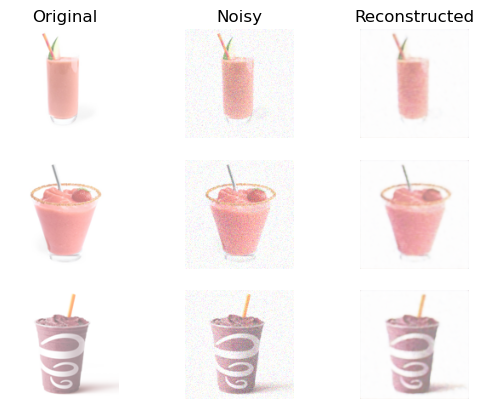

2024-03-03 06:44:41.171496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:41.758434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 201, Loss: 0.0025967005640268326


2024-03-03 06:44:42.378452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:42.938983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 202, Loss: 0.002532048267312348


2024-03-03 06:44:43.520886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:44.098500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 203, Loss: 0.0027428579051047564


2024-03-03 06:44:44.682895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:45.249407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 204, Loss: 0.002667663968168199


2024-03-03 06:44:45.833508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:46.416624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 205, Loss: 0.0028279535472393036


2024-03-03 06:44:46.992580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:47.572272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 206, Loss: 0.0026876501506194472


2024-03-03 06:44:48.156287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:48.724810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 207, Loss: 0.0025593764148652554


2024-03-03 06:44:49.301177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:49.893746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 208, Loss: 0.002611511619761586


2024-03-03 06:44:50.472542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:51.056453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 209, Loss: 0.002816464053466916


2024-03-03 06:44:51.650993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:52.233542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 210, Loss: 0.002749651554040611
1/1 [==============================] - 0s 170ms/step


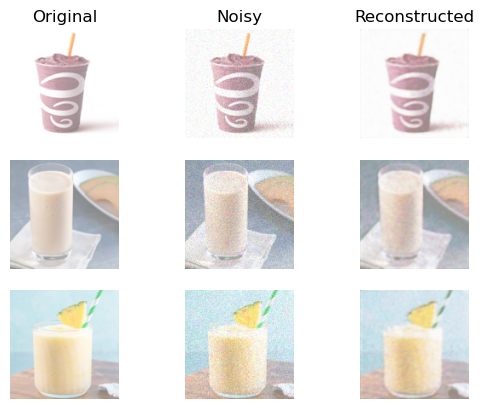

2024-03-03 06:44:53.175722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:53.794429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 211, Loss: 0.002580754109658301


2024-03-03 06:44:54.365821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:54.924558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 212, Loss: 0.002690626191906631


2024-03-03 06:44:55.493951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:56.058881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 213, Loss: 0.002287654089741409


2024-03-03 06:44:56.628974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:57.200789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 214, Loss: 0.0028313356451690197


2024-03-03 06:44:57.764107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:58.352299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 215, Loss: 0.0025398905854672194


2024-03-03 06:44:58.942274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:44:59.518646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 216, Loss: 0.0027048701886087656


2024-03-03 06:45:00.080985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:00.646064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 217, Loss: 0.0025738803669810295


2024-03-03 06:45:01.205810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:01.767432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 218, Loss: 0.002445359597913921


2024-03-03 06:45:02.374935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:02.969704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 219, Loss: 0.0026071302127093077


2024-03-03 06:45:03.588426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:04.202732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 220, Loss: 0.002679827157407999
1/1 [==============================] - 0s 167ms/step


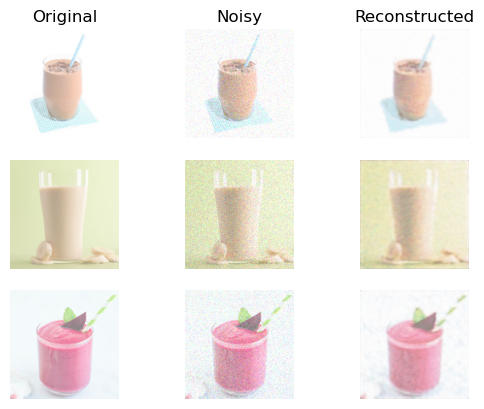

2024-03-03 06:45:05.142442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:05.749451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 221, Loss: 0.002439916366711259


2024-03-03 06:45:06.310858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:06.865306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 222, Loss: 0.0026032074820250273


2024-03-03 06:45:07.415052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:08.002976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 223, Loss: 0.002920718165114522


2024-03-03 06:45:08.608791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:09.179327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 224, Loss: 0.0024162096669897437


2024-03-03 06:45:09.749193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:10.321297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 225, Loss: 0.002325365669094026


2024-03-03 06:45:10.910397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:11.519022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 226, Loss: 0.002142700832337141


2024-03-03 06:45:12.144116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:12.804300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 227, Loss: 0.0024782876716926694


2024-03-03 06:45:13.396087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:14.007404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 228, Loss: 0.0023128974717110395


2024-03-03 06:45:14.698384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:15.303717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 229, Loss: 0.0022772172233089805


2024-03-03 06:45:15.909039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:16.558730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 230, Loss: 0.002373873139731586
1/1 [==============================] - 0s 180ms/step


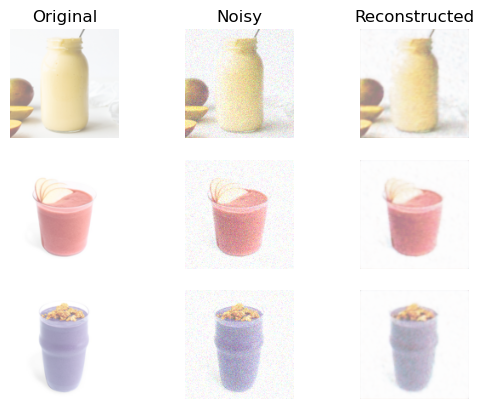

2024-03-03 06:45:17.574759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:18.199019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 231, Loss: 0.0023394873132929206


2024-03-03 06:45:18.792152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:19.399007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 232, Loss: 0.00237540400121361


2024-03-03 06:45:20.007261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:20.615647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 233, Loss: 0.0023026620037853718


2024-03-03 06:45:21.197895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:21.775397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 234, Loss: 0.002273321500979364


2024-03-03 06:45:22.337112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:22.913437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 235, Loss: 0.0023699216544628143


2024-03-03 06:45:23.483002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:24.067513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 236, Loss: 0.0026570288464426994


2024-03-03 06:45:24.630141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:25.212372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 237, Loss: 0.0023436868796125054


2024-03-03 06:45:25.779094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:26.362048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 238, Loss: 0.0021471985382959247


2024-03-03 06:45:26.974192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:27.581473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 239, Loss: 0.0026576148811727762


2024-03-03 06:45:28.167544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:28.765579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 240, Loss: 0.0020889287116006017
1/1 [==============================] - 0s 161ms/step


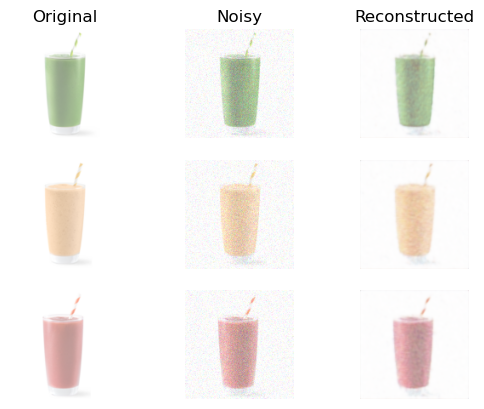

2024-03-03 06:45:29.674860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:30.315955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 241, Loss: 0.0024179829051718116


2024-03-03 06:45:30.895702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:31.505670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 242, Loss: 0.0022502803476527333


2024-03-03 06:45:32.096207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:32.665191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 243, Loss: 0.0022086899261921644


2024-03-03 06:45:33.221149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:33.782085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 244, Loss: 0.0024591252440586686


2024-03-03 06:45:34.341882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:34.900021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 245, Loss: 0.0025016466388478875


2024-03-03 06:45:35.457133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:36.017277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 246, Loss: 0.0025042988127097487


2024-03-03 06:45:36.578848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:37.134974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 247, Loss: 0.0021801864495500922


2024-03-03 06:45:37.689192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:38.245734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 248, Loss: 0.00231064110994339


2024-03-03 06:45:38.797095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:39.349767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 249, Loss: 0.0022979353088885546


2024-03-03 06:45:39.907416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:40.466917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 250, Loss: 0.0022893425775691867
1/1 [==============================] - 0s 154ms/step


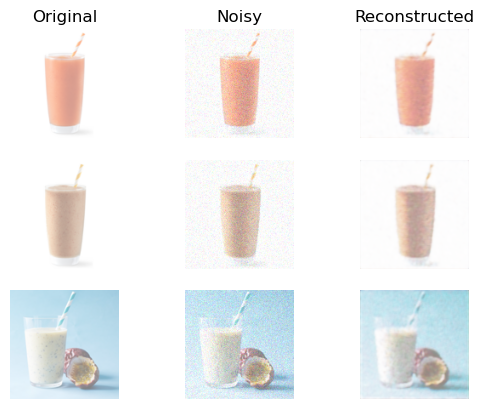

2024-03-03 06:45:41.346379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:41.915743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 251, Loss: 0.0024473131634294987


2024-03-03 06:45:42.466800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:43.031787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 252, Loss: 0.002355898031964898


2024-03-03 06:45:43.577401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:44.131885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 253, Loss: 0.002203011652454734


2024-03-03 06:45:44.684323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:45.235961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 254, Loss: 0.0023089286405593157


2024-03-03 06:45:45.790055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:46.411121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 255, Loss: 0.002187462756410241


2024-03-03 06:45:46.983440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:47.562832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 256, Loss: 0.0022665290161967278


2024-03-03 06:45:48.144976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:48.731138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 257, Loss: 0.0023404054809361696


2024-03-03 06:45:49.288807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:49.870261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 258, Loss: 0.002331505180336535


2024-03-03 06:45:50.465403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:51.043117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 259, Loss: 0.0023001222871243954


2024-03-03 06:45:51.618666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:52.197308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 260, Loss: 0.002198731992393732
1/1 [==============================] - 0s 159ms/step


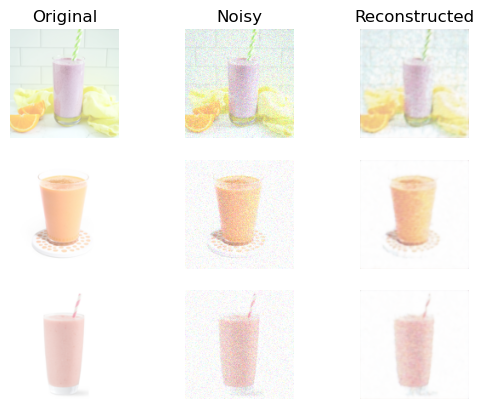

2024-03-03 06:45:53.096236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:53.689447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 261, Loss: 0.0023601322900503874


2024-03-03 06:45:54.292877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:54.904211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 262, Loss: 0.002246227813884616


2024-03-03 06:45:55.475763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:56.056863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 263, Loss: 0.00242363044526428


2024-03-03 06:45:56.640607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:57.221651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 264, Loss: 0.002125849132426083


2024-03-03 06:45:57.798320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:58.388915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 265, Loss: 0.002509283251129091


2024-03-03 06:45:58.996682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:45:59.572726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 266, Loss: 0.0025644865818321705


2024-03-03 06:46:00.159332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:00.728381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 267, Loss: 0.0022638088557869196


2024-03-03 06:46:01.300052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:01.900746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 268, Loss: 0.0025286638410761952


2024-03-03 06:46:02.545977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:03.132109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 269, Loss: 0.0026288360822945833


2024-03-03 06:46:03.701000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:04.284054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 270, Loss: 0.002960616140626371
1/1 [==============================] - 0s 156ms/step


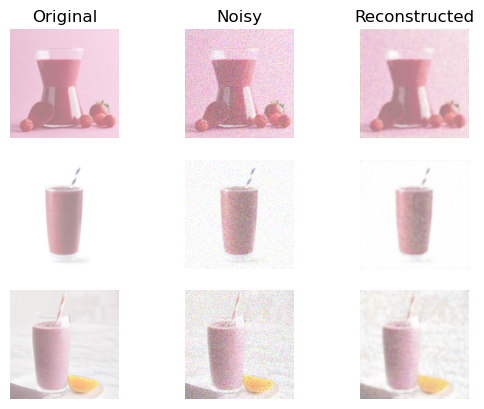

2024-03-03 06:46:05.180757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:05.749721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 271, Loss: 0.002789562684483826


2024-03-03 06:46:06.313281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:06.873564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 272, Loss: 0.0023580180713906884


2024-03-03 06:46:07.446539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:08.019604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 273, Loss: 0.0025209918385371566


2024-03-03 06:46:08.610451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:09.177150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 274, Loss: 0.0030030315974727273


2024-03-03 06:46:09.742082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:10.342545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 275, Loss: 0.0029994831420481205


2024-03-03 06:46:10.932965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:11.509789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 276, Loss: 0.002937116427347064


2024-03-03 06:46:12.084896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:12.673398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 277, Loss: 0.0026603620499372482


2024-03-03 06:46:13.262085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:13.823685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 278, Loss: 0.0030233149882405996


2024-03-03 06:46:14.406691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:15.032900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 279, Loss: 0.0026004258543252945


2024-03-03 06:46:15.613947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:16.195004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 280, Loss: 0.002482340205460787
1/1 [==============================] - 0s 167ms/step


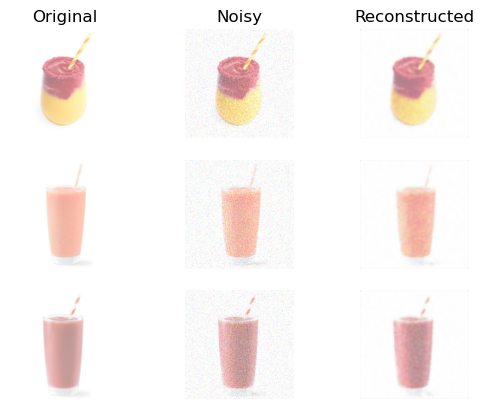

2024-03-03 06:46:17.094542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:17.686703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 281, Loss: 0.002667119144462049


2024-03-03 06:46:18.278839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:18.854730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 282, Loss: 0.0022282693535089493


2024-03-03 06:46:19.437502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:20.019246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 283, Loss: 0.002586877206340432


2024-03-03 06:46:20.594649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:21.179723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 284, Loss: 0.0024058924755081534


2024-03-03 06:46:21.771255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:22.351877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 285, Loss: 0.0020786770619452


2024-03-03 06:46:22.933198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:23.514593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 286, Loss: 0.0023687733337283134


2024-03-03 06:46:24.089282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:24.670760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 287, Loss: 0.0026832809671759605


2024-03-03 06:46:25.239588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:25.800060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 288, Loss: 0.0025929748080670834


2024-03-03 06:46:26.364492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:26.945630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 289, Loss: 0.0022694708313792944


2024-03-03 06:46:27.516387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:28.087996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 290, Loss: 0.0023232790408656
1/1 [==============================] - 0s 156ms/step


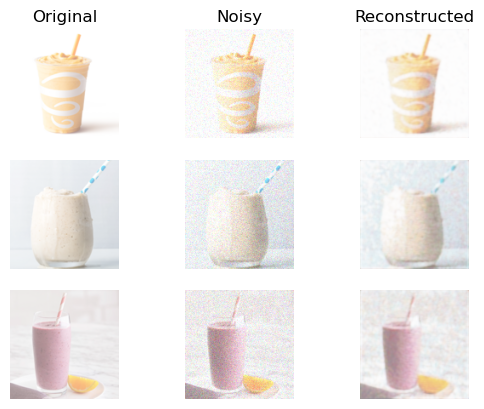

2024-03-03 06:46:29.149909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:29.756377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 291, Loss: 0.0024154315469786525


2024-03-03 06:46:30.329028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:30.925089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 292, Loss: 0.002288438845425844


2024-03-03 06:46:31.519912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:32.121856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 293, Loss: 0.0023218225687742233


2024-03-03 06:46:32.705490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:33.304462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 294, Loss: 0.002484889351762831


2024-03-03 06:46:33.880911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:34.512673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 295, Loss: 0.0022019927855581045


2024-03-03 06:46:35.113175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:35.687483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 296, Loss: 0.0020166512113064528


2024-03-03 06:46:36.276990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:36.859250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 297, Loss: 0.0021690817084163427


2024-03-03 06:46:37.451151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:38.011163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 298, Loss: 0.0022803684696555138


2024-03-03 06:46:38.598061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:39.179502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 299, Loss: 0.0023276248248293996


2024-03-03 06:46:39.756490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 06:46:40.334871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 300, Loss: 0.0020841668592765927
1/1 [==============================] - 0s 159ms/step


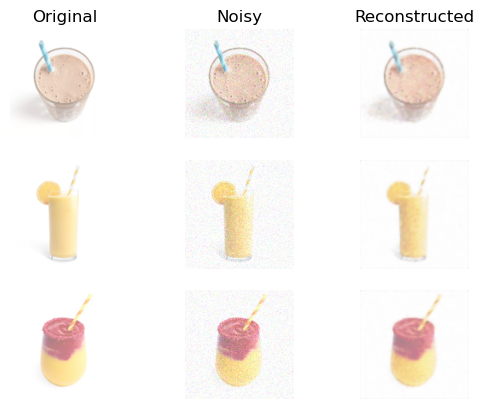

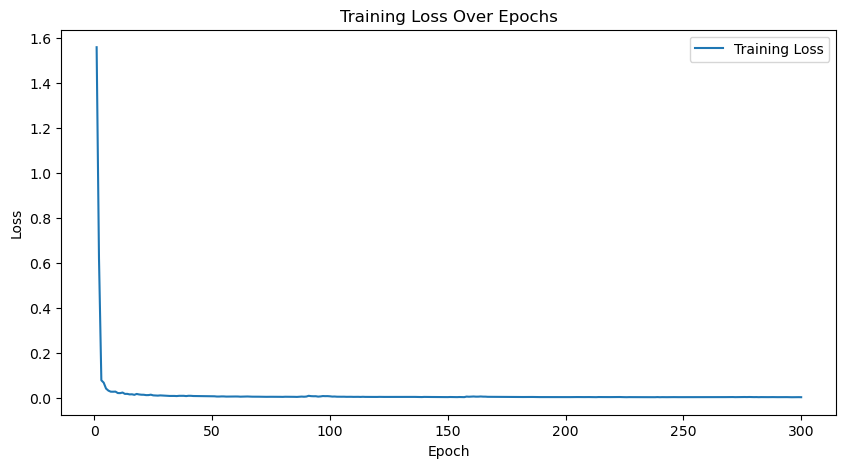

In [116]:
'''Training Execution'''
epochs = 300  # Set the number of epochs. Used to be 50
batch_size = 32  # Set the batch size. Used to be 32
steps_per_epoch = X_train.shape[0] // batch_size  # Assuming X_train is your dataset

# Placeholder for storing training loss
training_loss = []

for epoch in range(epochs):
    epoch_loss = 0
    for step in range(steps_per_epoch):
        # Sample a batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]
        
        # Apply the forward diffusion process (add noise)
        noisy_images = add_noise(real_images)
        
        # Train the model on this batch
        loss_value = model.train_on_batch(noisy_images, real_images)
        epoch_loss += loss_value
        
    # Calculate average loss for the epoch
    epoch_loss /= steps_per_epoch
    training_loss.append(epoch_loss)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    
    # Optionally display some reconstructed images at intervals
    if (epoch + 1) % 10 == 0:
        # Select a random batch of images
        test_idx = np.random.randint(0, X_train.shape[0], batch_size)
        test_images = X_train[test_idx]
        noisy_test_images = add_noise(test_images)
        reconstructed_images = model.predict(noisy_test_images)
        
        # Plot original, noisy, and reconstructed images
        for i in range(3):
            plt.subplot(3, 3, i*3 + 1)
            plt.imshow(test_images[i] * 0.5 + 0.5)  # Assuming images were normalized to [-1, 1]
            plt.axis('off')
            if i == 0:
                plt.title('Original')
            plt.subplot(3, 3, i*3 + 2)
            plt.imshow(noisy_test_images[i] * 0.5 + 0.5)
            plt.axis('off')
            if i == 0:
                plt.title('Noisy')
            plt.subplot(3, 3, i*3 + 3)
            plt.imshow(reconstructed_images[i] * 0.5 + 0.5)
            plt.axis('off')
            if i == 0:
                plt.title('Reconstructed')
        plt.show()

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), training_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


### Evaluation and Testing
- Generate images using the trained model and compare them to real images to assess quality.

This cell covers:
- Generating images by feeding noise to the trained model and running the reverse diffusion process.
- Displaying the generated images to visually evaluate how well the model has learned to generate smoothie images.
- Comparing with real images from the dataset for a direct quality assessment.

In [ ]:
'''Evaluation and Testing'''
def display_images(images, title):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)  # Assuming images were normalized to [-1, 1]
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Generate images from noise
num_samples = 9  # Number of images to generate
noise = np.random.normal(size=(num_samples, 128, 128, 3))  # Assuming the model inputs are 128x128x3 images
generated_images = model.predict(noise)

# Display generated images
display_images(generated_images, 'Generated Images')

# Optionally, compare with real images from the dataset
# Select a random sample of real images
real_image_indices = np.random.randint(0, X_train.shape[0], num_samples)
real_images = X_train[real_image_indices]

# Display real images
display_images(real_images, 'Real Images')


### Integration Instructions
- Outline how to integrate the model into your Flask application.

To integrate the trained model into your Flask application:
- Save the trained model.
- Load the model in your Flask application.
- Create an endpoint that receives ingredient information, generates a noise vector, and uses the model to generate a smoothie image.
- Return the generated image in response to the request.

In [ ]:
'''Integration Instructions'''
